# ATP Tennis Data - Player Diff Stats + One Hot Encoding (All Categorical Data) + Player History


In our previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/5.2-atp_diff-ohe.ipynb), we did not see any improvement from encoding more categorical columns in our model. In fact we saw as slight decrease in our precision for predicting losses

In this notebook, we will run the same algorithms but we will add historical data from player 1 and 2. Historical data was created in this [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/6-apt_advanced_feature_engineering-history.ipynb) where we aggregated match data for each player for the most recent 5 matches leading up to each match

We will only add this data to our dataset:

* p1_history_win_percentage_diff - player 1 win percentage history - player 2 win percentage history
* p1_history_games_won_percentage_diff = player 1 games won percentage - player 2 games won percentage
* p1_history_sets_won_percentage_diff = player 1 sets won percetntage - player 2 sets won percentage
* p1_history_wins_diff = player 1 wins - player 2 wins
* p1_history_losses_diff = player 1 losses - player 2 losses

We will see if this data helps improve our models

### Results that did the best model so far

```
Model Score: 0.6906819716407833

ROC/AUC Score: 0.6906426130517523
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.70      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810
```


# Summary of Results


Diffing history data instead of using all history data for both players seems to be getting the best results out of the subset of history data so far.

```
Model Score: 0.6888588791357191

ROC/AUC Score: 0.6888267232652099
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.69      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810
```



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, REPORT_FILE, RSTATE, N_JOBS, MAX_ITER, LABEL_COL

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "ohe-history_diff"


# update this
FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-ohe-history5-matchup5.csv'

START_YEAR = 1998
END_YEAR = 2018




In [2]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR)

Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

In [3]:
import re
matchup_columns = [col for col in X_train.columns if re.search('matchup', col)]
print(f'Before: X_train.shape {X_train.shape} X_test.shape {X_test.shape}')
X_train = X_train.drop(matchup_columns, axis=1)
X_test = X_test.drop(matchup_columns, axis=1)

# drop all history columns that doesn't have percentage
history_columns = [col for col in X_train.columns if re.search('history', col) and not re.search('diff', col)]
X_train = X_train.drop(history_columns, axis=1)
X_test = X_test.drop(history_columns, axis=1)

print(f'After: X_train.shape {X_train.shape} X_test.shape {X_test.shape}')

Before: X_train.shape (44429, 5299) X_test.shape (14810, 5299)
After: X_train.shape (44429, 5262) X_test.shape (14810, 5262)


In [4]:
[col for col in X_train.columns if re.search('history', col)]

['p1_history_win_percentage_diff',
 'p1_history_games_won_percentage_diff',
 'p1_history_sets_won_percentage_diff',
 'p1_history_wins_diff',
 'p1_history_losses_diff']

# Logistic Regression

In [5]:

# train our model

lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_lr = lr.predict()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

Model Score: 0.6632680621201891

ROC/AUC Score: 0.6632651814406203
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66      7381
         Win       0.66      0.66      0.66      7429

    accuracy                           0.66     14810
   macro avg       0.66      0.66      0.66     14810
weighted avg       0.66      0.66      0.66     14810

      Loss   Win
Loss  4889  2492
Win   2495  4934


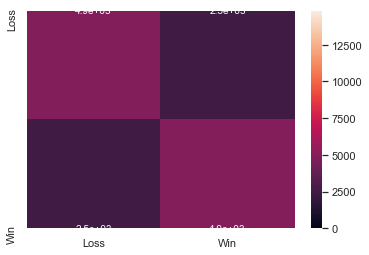

In [6]:
lr.analyze()

In [7]:
# ju.plot_2d(X_test, y_predict_lr)

In [8]:
lr.save()

Saving report: ../reports/summary.csv


# KNN

In [9]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_knn = knn.predict()

Model Score: 0.6086428089128967

ROC/AUC Score: 0.6086531416252878
              precision    recall  f1-score   support

        Loss       0.61      0.61      0.61      7381
         Win       0.61      0.61      0.61      7429

    accuracy                           0.61     14810
   macro avg       0.61      0.61      0.61     14810
weighted avg       0.61      0.61      0.61     14810

      Loss   Win
Loss  4516  2865
Win   2931  4498


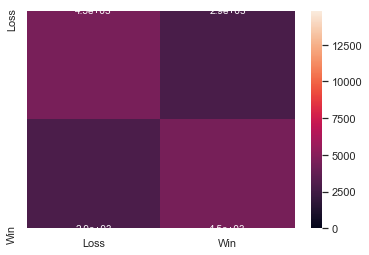

In [10]:
knn.analyze()

In [11]:
# ju.plot_2d(X_test, y_predict_knn)

In [12]:
knn.save()

Saving report: ../reports/summary.csv


# Decision Tree

In [13]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_dt = dt.predict()

Model Score: 0.5987170830519919

ROC/AUC Score: 0.5987218403861482
              precision    recall  f1-score   support

        Loss       0.60      0.60      0.60      7381
         Win       0.60      0.60      0.60      7429

    accuracy                           0.60     14810
   macro avg       0.60      0.60      0.60     14810
weighted avg       0.60      0.60      0.60     14810

      Loss   Win
Loss  4430  2951
Win   2992  4437


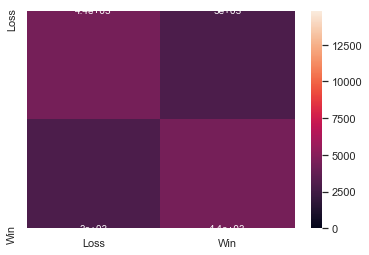

In [14]:
dt.analyze()

In [15]:
# ju.plot_2d(X_test, y_predict_dt)

In [16]:
dt.save()

Saving report: ../reports/summary.csv


# Random Forest Classifier

In [17]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_rf = rf.predict()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.6437542201215395

ROC/AUC Score: 0.6439754500943392
              precision    recall  f1-score   support

        Loss       0.63      0.71      0.67      7381
         Win       0.67      0.58      0.62      7429

    accuracy                           0.64     14810
   macro avg       0.65      0.64      0.64     14810
weighted avg       0.65      0.64      0.64     14810

      Loss   Win
Loss  5257  2124
Win   3152  4277


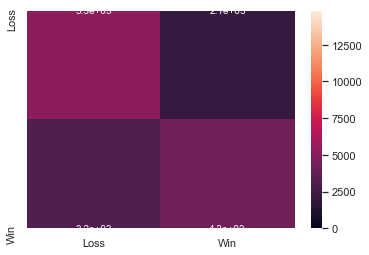

In [18]:
rf.analyze()

In [19]:
# ju.plot_2d(X_test, y_predict_rf)

In [20]:
rf.save()

Saving report: ../reports/summary.csv


# Gradient Boosting

In [21]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3661            8.88m
         2           1.3496            8.79m
         3           1.3353            8.74m
         4           1.3232            8.69m
         5           1.3127            8.62m
         6           1.3036            8.52m
         7           1.2961            8.43m
         8           1.2883            8.34m
         9           1.2819            8.25m
        10           1.2764            8.16m
        20           1.2320            7.22m
        30           1.2066            6.46m
        40           1.1922            5.53m
        50           1.1801            4.56m
        60           1.1717            3.66m
        70           1.1640            2.73m
        80           1.1583            1.81m
        90           1.1513           54.04s


Model Score: 0.6888588791357191

ROC/AUC Score: 0.6888267232652099
              precision    recall  f1-score   support

        Loss       0.69      0.68      0.69      7381
         Win       0.69      0.70      0.69      7429

    accuracy                           0.69     14810
   macro avg       0.69      0.69      0.69     14810
weighted avg       0.69      0.69      0.69     14810

      Loss   Win
Loss  5011  2370
Win   2238  5191


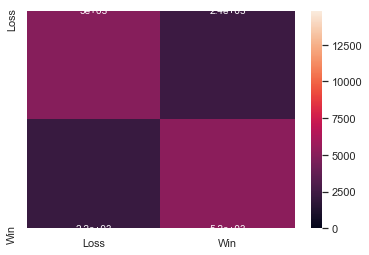

In [22]:
gb.analyze()

In [23]:
# ju.plot_2d(X_test, y_predict_gb)

In [24]:
gb.save()

Saving report: ../reports/summary.csv


# AdaBoost

In [25]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_ab = ab.predict()

Model Score: 0.6723835246455098

ROC/AUC Score: 0.6723455057514256
              precision    recall  f1-score   support

        Loss       0.68      0.66      0.67      7381
         Win       0.67      0.68      0.68      7429

    accuracy                           0.67     14810
   macro avg       0.67      0.67      0.67     14810
weighted avg       0.67      0.67      0.67     14810

      Loss   Win
Loss  4876  2505
Win   2347  5082


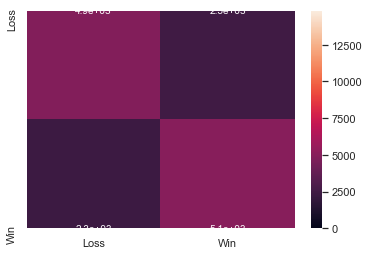

In [26]:
ab.analyze()

In [27]:
# ju.plot_2d(X_test, y_predict_ab)

In [28]:
ab.save()

Saving report: ../reports/summary.csv


# Results

In [29]:
report = pd.read_csv(REPORT_FILE)
report.tail(6)

,model_name,description,data_file,start_year,end_year,accuracy,roc_auc_score,confusion_matrix,classification_report,model_file,predict_time_min,fit_time_min,total_time_min
60,LogisticRegression,ohe-history_diff,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.663268,0.663265,"{""0"": {""0"": 4889, ""1"": 2495}, ""1"": {""0"": 2492,...","{""Loss"": {""precision"": 0.6621072589382448, ""re...",../models/logisticregression-1998-2018-ohe-his...,0.0,0.0,0.0
61,KNeighborsClassifier,ohe-history_diff,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.608643,0.608653,"{""0"": {""0"": 4516, ""1"": 2931}, ""1"": {""0"": 2865,...","{""Loss"": {""precision"": 0.6064186920907748, ""re...",../models/kneighborsclassifier-1998-2018-ohe-h...,0.0,0.0,0.0
62,DecisionTreeClassifier,ohe-history_diff,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.598717,0.598722,"{""0"": {""0"": 4430, ""1"": 2992}, ""1"": {""0"": 2951,...","{""Loss"": {""precision"": 0.5968741579089194, ""re...",../models/decisiontreeclassifier-1998-2018-ohe...,0.0,0.0,0.0
63,RandomForestClassifier,ohe-history_diff,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.643754,0.643975,"{""0"": {""0"": 5257, ""1"": 3152}, ""1"": {""0"": 2124,...","{""Loss"": {""precision"": 0.6251635152812463, ""re...",../models/randomforestclassifier-1998-2018-ohe...,0.0,0.0,0.0
64,GradientBoostingClassifier,ohe-history_diff,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.688859,0.688827,"{""0"": {""0"": 5011, ""1"": 2238}, ""1"": {""0"": 2370,...","{""Loss"": {""precision"": 0.6912677610704925, ""re...",../models/gradientboostingclassifier-1998-2018...,0.0,9.0,9.0
65,AdaBoostClassifier,ohe-history_diff,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.672384,0.672346,"{""0"": {""0"": 4876, ""1"": 2347}, ""1"": {""0"": 2505,...","{""Loss"": {""precision"": 0.6750657621486916, ""re...",../models/adaboostclassifier-1998-2018-ohe-his...,0.0,1.0,1.0


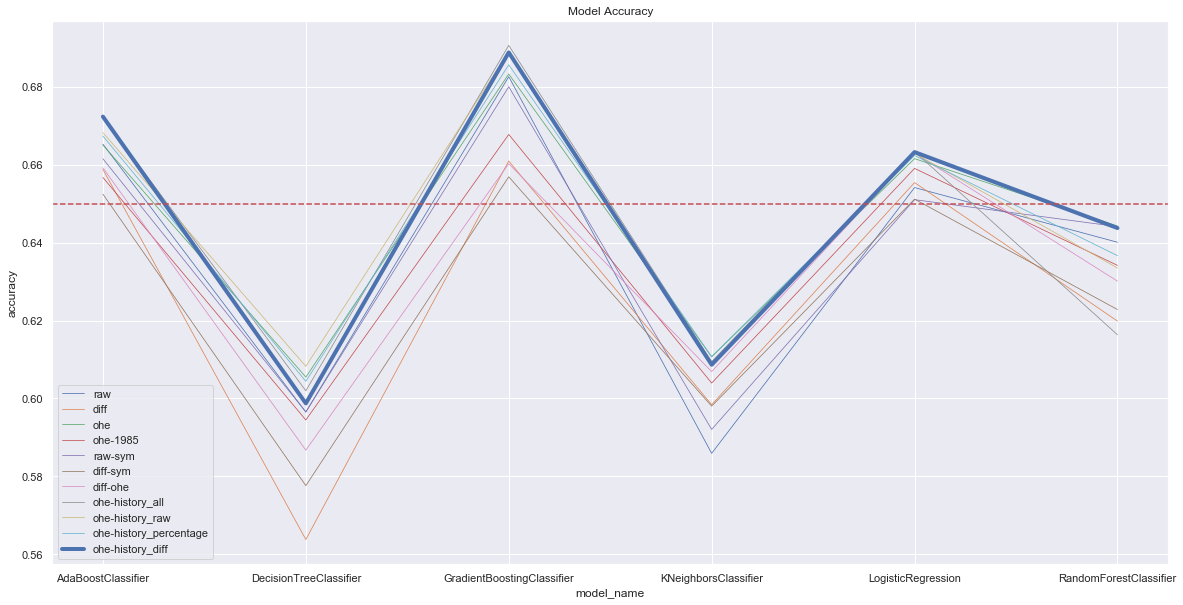

In [30]:
f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    if desc == DESCRIPTION:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
    else:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")
_ = a.legend(loc="lower left")

Best Model: GradientBoostingClassifier


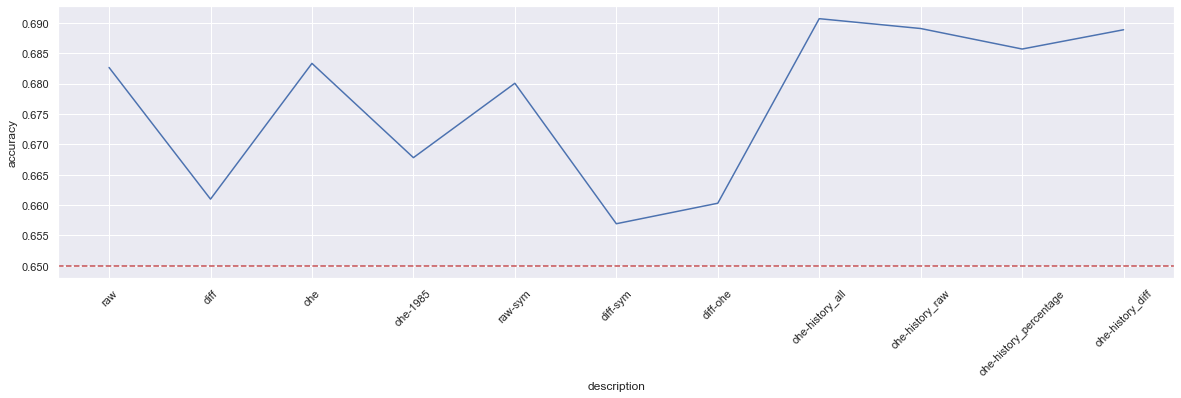

In [31]:
best_model = report.loc[report[report.description == DESCRIPTION].accuracy.idxmax()].model_name
print(f'Best Model: {best_model}')

dt_report = report[(report.model_name == best_model)]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.axhline(0.65, ls='--', color='r')
_ = a.set_label(f"{best_model} Accuracy")
_ = plt.xticks(rotation=45)


In [32]:

current_report = report[(report.model_name == best_model) &
                                  (report.description == DESCRIPTION)]
mw = ModelWrapper.get_model_wrapper_from_report(current_report)


In [33]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(mw.model, data=X_train.values)
shap_values = explainer.shap_values(X_test.values)

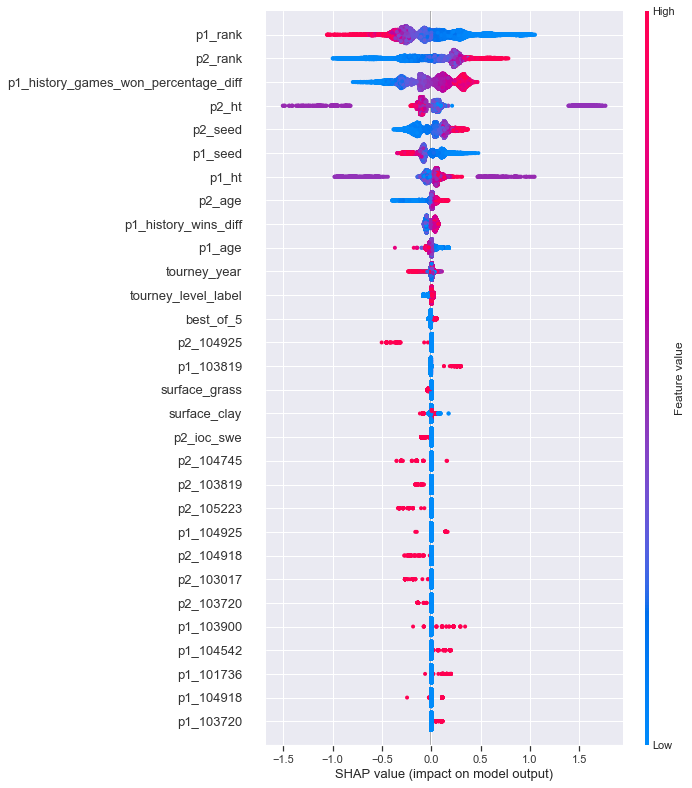

In [34]:
shap.summary_plot(shap_values, X_test, max_display=30)

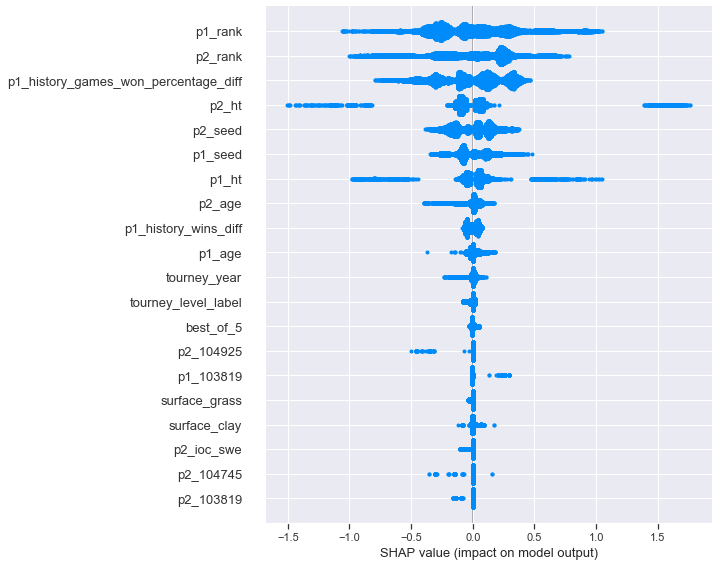

In [35]:
shap.summary_plot(shap_values, feature_names=X_test.columns, title="Feature Importance")

In [36]:
print(f'Last Finished: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Last Finished: 2019-10-21 03:01
